In [48]:
import pandas as pd
from langdetect import detect
from langdetect import detect_langs
import googletrans
from googletrans import Translator
from tabulate import tabulate
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud
stop_words = set(stopwords.words('english'))



In [3]:
tracks= pd.read_csv('data/spotify_tracks.csv')
columns = tracks.columns
columns


Index(['Unnamed: 0', 'acousticness', 'album_id', 'analysis_url', 'artists_id',
       'available_markets', 'country', 'danceability', 'disc_number',
       'duration_ms', 'energy', 'href', 'id', 'instrumentalness', 'key',
       'liveness', 'loudness', 'lyrics', 'mode', 'name', 'playlist',
       'popularity', 'preview_url', 'speechiness', 'tempo', 'time_signature',
       'track_href', 'track_name_prev', 'track_number', 'uri', 'valence',
       'type'],
      dtype='object')

In [4]:
columns = tracks.columns
columns

Index(['Unnamed: 0', 'acousticness', 'album_id', 'analysis_url', 'artists_id',
       'available_markets', 'country', 'danceability', 'disc_number',
       'duration_ms', 'energy', 'href', 'id', 'instrumentalness', 'key',
       'liveness', 'loudness', 'lyrics', 'mode', 'name', 'playlist',
       'popularity', 'preview_url', 'speechiness', 'tempo', 'time_signature',
       'track_href', 'track_name_prev', 'track_number', 'uri', 'valence',
       'type'],
      dtype='object')

In [5]:
tracks['lyrics']=tracks['lyrics'].str.replace('\r\n', ' ')
tracks=tracks.dropna()

In [6]:
def detect_language_and_confidence(df, column_name):
    """
    Detect the language and its confidence for each row in the specified column of the DataFrame.

    Parameters:
    - df: DataFrame
    - column_name: the column for which to detect the language

    Returns:
    - DataFrame with new columns named 'language' and 'confidence' containing detected languages and their confidences
    """
    
    def get_lang_confidence(text):
        try:
            detected = detect_langs(text)
            # Assuming the most probable language is the one we want
            lang = detected[0].lang
            conf = detected[0].prob
            return lang, conf
        except:
            return 'unknown', None

    df['language'], df['confidence'] = zip(*df[column_name].map(get_lang_confidence))
    
    return df


In [7]:
lyrics_lang=detect_language_and_confidence(tracks,'lyrics')
c1=lyrics_lang.columns[0]
tracks_lang = lyrics_lang.drop(columns=c1)

In [8]:
tracks_lang.to_csv('data/tracks_spotify_lang.csv', index=False)

In [9]:
tracks_lang=pd.read_csv('data/tracks_spotify_lang.csv')
filtered_df = tracks_lang[~tracks_lang['language'].isin(['en', 'unknown'])]

In [10]:
filtered_df[['id','lyrics','language','confidence']]

,id,lyrics,language,confidence
35,58QDB1sKe1wHZEvngevtGE,"Entiende, que tu misma te haces daño Al pedir...",es,0.999996
40,568qmPhxzAiB6SXxZeRBjg,18 kilates...!! Ya yo me olvide ti Ya yo me o...,es,0.999997
45,6lgHNsNnN2ohPCBPtXwqvI,18 kilates...!! Ya yo me olvide ti Ya yo me o...,es,0.999996
50,6P0a1zjJ0rbw59c3Wah6pn,No me llamas y te la pasas a escondidas Estoy...,es,0.999996
55,6jIHs2L87ZsXMxx2zbZwH5,"Cansado de buscar, y herido en mil fracasos...",es,0.999997
...,...,...,...,...
101905,0dFZjxL6drxK9oupqmF773,Quisiera empezar Volver a cruzar despacio Ima...,es,0.999996
101906,29WK73lMQpLELfHd6PfbjY,Quisiera empezar Volver a cruzar despacio Ima...,es,0.999996
101909,3zZ4thsaNvldGqqZz34cLc,"Gefährliche Kiki, Kiki, ba-da, ba-ba-bau Mi...",de,0.999994
101910,46rtM64AlJF9Kxf1c1Eie6,Eine Vinyl aus der Hülle zieh'n (eins-a) Si...,de,0.999998


In [11]:
filtered_df['char_count'] = filtered_df['lyrics'].str.len()

/var/folders/bf/3n7wxjyn0rl9rrhzmyw8mb7w0000gn/T/ipykernel_50986/3645812127.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['char_count'] = filtered_df['lyrics'].str.len()


In [12]:
def translate_lyrics(df, column_name, lan_src_column):
    """
    Translate the text for each row in the specified column of the DataFrame.

    Parameters:
    - df: DataFrame
    - column_name: str, the column to translate the text
    - lan_src_column: str, the column containing source language codes

    Returns:
    - DataFrame with a new column named 'text_trans' containing translated texts
    """
    
    translator = Translator()
    translation_count = 0
    
    def get_translation(row, text_column, lan_src_column):
        nonlocal translation_count
        text = row[text_column]
        lan_scr = row[lan_src_column]
        try:
            # Translate the text and return it
            translated_text = translator.translate(text, dest='en', src=lan_scr).text
            translation_count += 1
            return translated_text
        except Exception as e:
            print(f"Translation error: {e}")
            return None

    # Apply the translation function to the DataFrame and store the result in a new column 'text_trans'
    df['text_trans'] = df.apply(lambda row: get_translation(row, column_name, lan_src_column), axis=1)
    
    print(f"Translated {translation_count} rows.")
    
    return df

In [13]:
#translate_lyrics(filtered_df,'lyrics','language')

In [14]:
translator = Translator()
my_translation = translator.translate(filtered_df['lyrics'][35], src='es', dest='en')
print(my_translation.text)

AttributeError: 'NoneType' object has no attribute 'group'

In [15]:
tracks_lang_no_dup = tracks_lang.drop_duplicates(subset='lyrics', keep='first').reset_index()


In [16]:
len(tracks_lang_no_dup)


40816

In [17]:
countries = tracks_lang_no_dup['language'].value_counts().head(10)
countries

language
en    25732
es     6082
pt     1943
fr     1441
de      878
fi      754
it      747
sv      676
da      538
nl      454
Name: count, dtype: int64

In [18]:
tracks_lang_no_dup['lyrics'] = tracks_lang_no_dup['lyrics'].str.lower()
tracks_lang_no_dup = tracks_lang_no_dup[tracks_lang_no_dup['language'].isin(['en'])]

In [19]:
tracks_lang_no_dup['lyrics']

0          perhaps i am bound to be restless always yea...
1         your gods and my gods-do you or i know which ...
2          closed off from love, i didn't need the pain...
3         pain, n. an uncomfortable frame of mind that ...
4         if there were an ocean we’d be wading in the ...
                               ...                        
40811      black fingernails, red wine i wanna make you...
40812      i got killed by black bugs on my video game ...
40813     no more maybes your baby's got rabies sitting...
40814     walking down the street with some evil in my ...
40815     there's not enough hours in my day to tell yo...
Name: lyrics, Length: 25732, dtype: object

In [20]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mervetaskaya/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [21]:
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    return " ".join([word for word in words if word.lower() not in stop_words])

tracks_lang_no_dup['lyrics'] = tracks_lang_no_dup['lyrics'].apply(remove_stopwords)

In [22]:
def tokenize_text(text):
    return nltk.word_tokenize(str(text))

In [23]:
tracks_lang_no_dup['lyrics'] = tracks_lang_no_dup['lyrics'].apply(tokenize_text)

In [24]:
filtered_df = tracks_lang_no_dup[tracks_lang_no_dup['id'] == '0RKqylCDwg0Lzq8Stu266U'] ['lyrics']
a=filtered_df.iloc[0]
a

['shine',
 'bright',
 'like',
 'diamond',
 'shine',
 'bright',
 'like',
 'diamond',
 'shining',
 'bright',
 'like',
 'diamond',
 'find',
 'light',
 'beautiful',
 'sea',
 'choose',
 'happy',
 ',',
 "'re",
 'like',
 'diamonds',
 'sky',
 "'re",
 'shooting',
 'star',
 'see',
 'visions',
 'ecstasy',
 'hold',
 ',',
 "'m",
 'alive',
 "'re",
 'like',
 'diamonds',
 'sky',
 'knew',
 "'d",
 'become',
 'one',
 'right',
 'away',
 'oh',
 ',',
 'right',
 'away',
 'first',
 'sight',
 'felt',
 'energy',
 'sun',
 'rays',
 'saw',
 'life',
 'inside',
 'eyes',
 'shine',
 'bright',
 ',',
 'tonight',
 "'re",
 'beautiful',
 'like',
 'diamonds',
 'sky',
 'eye',
 'eye',
 ',',
 'alive',
 "'re",
 'beautiful',
 'like',
 'diamonds',
 'sky',
 'shine',
 'bright',
 'like',
 'diamond',
 'shine',
 'bright',
 'like',
 'diamond',
 'shining',
 'bright',
 'like',
 'diamond',
 "'re",
 'beautiful',
 'like',
 'diamonds',
 'sky',
 'shine',
 'bright',
 'like',
 'diamond',
 'shine',
 'bright',
 'like',
 'diamond',
 'shining',
 'b

In [25]:
tracks_lang_no_dup['WordCount'] = tracks_lang_no_dup['lyrics'].apply(len)
filtered_df = tracks_lang_no_dup[tracks_lang_no_dup['WordCount'] < 5000]

In [26]:
len(filtered_df)

25694

In [27]:
tracks_lang_no_dup[['WordCount','lyrics','name']].sort_values(by='WordCount',ascending=False)

,WordCount,lyrics,name
28831,29577,"[summary, evidence, monell, policy, practice, ...",Hard to Say I'm Sorry / Get Away - Remastered
33931,20379,"[last, updated, :, 10/6/2018, ,, 5:16pm, mst, ...",Zigo (Remix) [feat. Diamond Platnumz]
18967,15697,"[life, milton, already, written, many, forms, ...",Kig Forbi
3455,14425,"[&, nbsp, verse, 1., foolish, galatians, ., ap...",Psalm 60
10,14160,"[1., city, snakes, eddie, runs, stage, ,, jump...",Angly-Saxy English
...,...,...,...
37107,2,"[lyrics, re-transcribed]",Blood Fire
1453,2,"[linda, ronstadt]",Ta Ta Dios (Father God)
9009,1,[yo],Mi Ex
21825,1,[pay],Pay (For What)


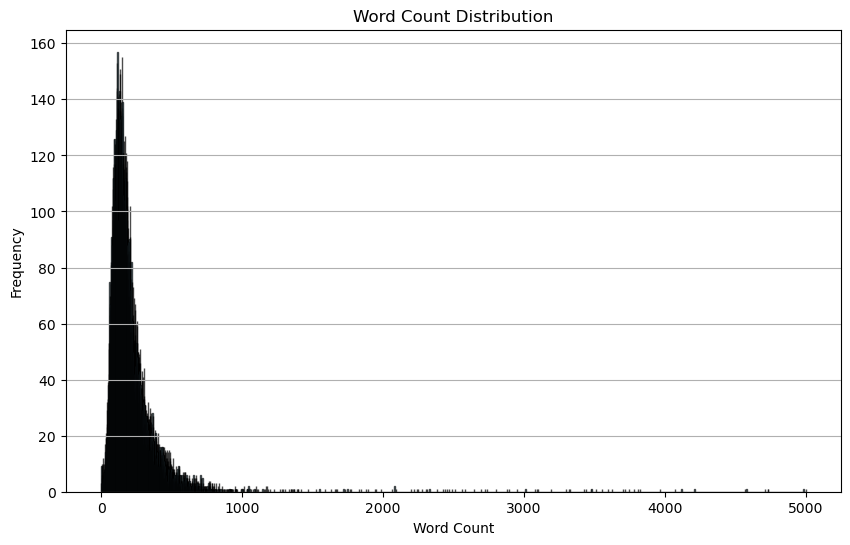

In [28]:
plt.figure(figsize=(10, 6))
plt.hist(filtered_df['WordCount'], bins=range(0, filtered_df['WordCount'].max() + 1), alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Word Count Distribution')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()

In [29]:
filtered_df

,index,acousticness,album_id,analysis_url,artists_id,available_markets,country,danceability,disc_number,duration_ms,...,time_signature,track_href,track_name_prev,track_number,uri,valence,type,language,confidence,WordCount
0,0,0.29400,0D3QufeCudpQANOR7luqdr,https://api.spotify.com/v1/audio-analysis/5qlj...,['3mxJuHRn2ZWD5OofvJtDZY'],"['AD', 'AE', 'AR', 'AT', 'AU', 'BE', 'BG', 'BH...",BE,0.698,1.0,235584.0,...,4.0,https://api.spotify.com/v1/tracks/5qljLQuKnNJf...,track_14,1.0,spotify:track:5qljLQuKnNJf4F4vfxQB0V,0.622,track,en,0.999995,104
1,1,0.86300,1bcqsH5UyTBzmh9YizdsBE,https://api.spotify.com/v1/audio-analysis/3VAX...,['4xWMewm6CYMstu0sPgd9jJ'],"['AD', 'AE', 'AR', 'AT', 'AU', 'BE', 'BG', 'BH...",BE,0.719,1.0,656960.0,...,3.0,https://api.spotify.com/v1/tracks/3VAX2MJdmdqA...,track_3,3.0,spotify:track:3VAX2MJdmdqARLSU5hPMpm,0.589,track,en,0.999997,3190
2,2,0.75000,4tKijjmxGClg4JOLAyo2qE,https://api.spotify.com/v1/audio-analysis/1L3Y...,['3hYaK5FF3YAglCj5HZgBnP'],['GB'],BE,0.466,1.0,492840.0,...,4.0,https://api.spotify.com/v1/tracks/1L3YAhsEMrGV...,track_4,4.0,spotify:track:1L3YAhsEMrGVvCgDXj2TYn,0.085,track,en,0.999995,253
3,3,0.76300,6FeJF5r8roonnKraJxr4oB,https://api.spotify.com/v1/audio-analysis/6aCe...,['2KQsUB9DRBcJk17JWX1eXD'],"['AD', 'AE', 'AR', 'AT', 'AU', 'BE', 'BG', 'BH...",BE,0.719,1.0,316578.0,...,3.0,https://api.spotify.com/v1/tracks/6aCe9zzoZmCo...,track_9,1.0,spotify:track:6aCe9zzoZmCojX7bbgKKtf,0.533,track,en,0.999998,2879
4,5,0.97100,7CCwkPweMxKq8yWkVerH6T,https://api.spotify.com/v1/audio-analysis/4PrA...,['3kzwYV3OCB010YfXMF0Avt'],"['AE', 'AR', 'BH', 'BO', 'BR', 'CL', 'CO', 'CR...",BE,0.367,1.0,183653.0,...,4.0,https://api.spotify.com/v1/tracks/4PrAZpH9Ic7S...,track_23,8.0,spotify:track:4PrAZpH9Ic7S47E78BN6E4,0.192,track,en,0.999997,68
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40811,101933,0.00837,4PXy3cBCNeY0ZVKTOGi9Cw,https://api.spotify.com/v1/audio-analysis/0ujk...,['3yW6jTzGjHUUkLvLkjLOVn'],"['AU', 'NZ']",AR,0.553,1.0,251253.0,...,4.0,https://api.spotify.com/v1/tracks/0ujklxrVM2jw...,track_7,3.0,spotify:track:0ujklxrVM2jwpLMgbTwTd1,0.418,track,en,0.999997,159
40812,101934,0.00564,1M9n4vCmOH4lbcHrpt21Qy,https://api.spotify.com/v1/audio-analysis/4e5w...,['6n3YUZcayLRuAunJUUelvz'],"['AU', 'NZ']",AR,0.602,1.0,178893.0,...,4.0,https://api.spotify.com/v1/tracks/4e5wI6VC4eVD...,track_10,4.0,spotify:track:4e5wI6VC4eVDTtpyZ409Pw,0.787,track,en,0.999998,128
40813,101936,0.00451,511p6iaCuK8Sr0BYdpcfkq,https://api.spotify.com/v1/audio-analysis/2RDg...,['4iudEcmuPlYNdbP3e1bdn1'],"['AD', 'AE', 'AR', 'AT', 'AU', 'BE', 'BG', 'BH...",AR,0.539,1.0,226107.0,...,4.0,https://api.spotify.com/v1/tracks/2RDgs05sg2vr...,track_21,2.0,spotify:track:2RDgs05sg2vrpwiAEUkWd0,0.406,track,en,0.999997,104
40814,101937,0.33300,7H3Bgvb3hs4vvLwccHDRlr,https://api.spotify.com/v1/audio-analysis/1pXt...,['023YMawCG3OvACmRjWxLWC'],"['AD', 'AE', 'AR', 'AT', 'AU', 'BE', 'BG', 'BH...",AR,0.716,1.0,224133.0,...,4.0,https://api.spotify.com/v1/tracks/1pXtUVmSS3Ak...,track_26,5.0,spotify:track:1pXtUVmSS3Aky3j6nQ4sQT,0.760,track,en,0.999998,212


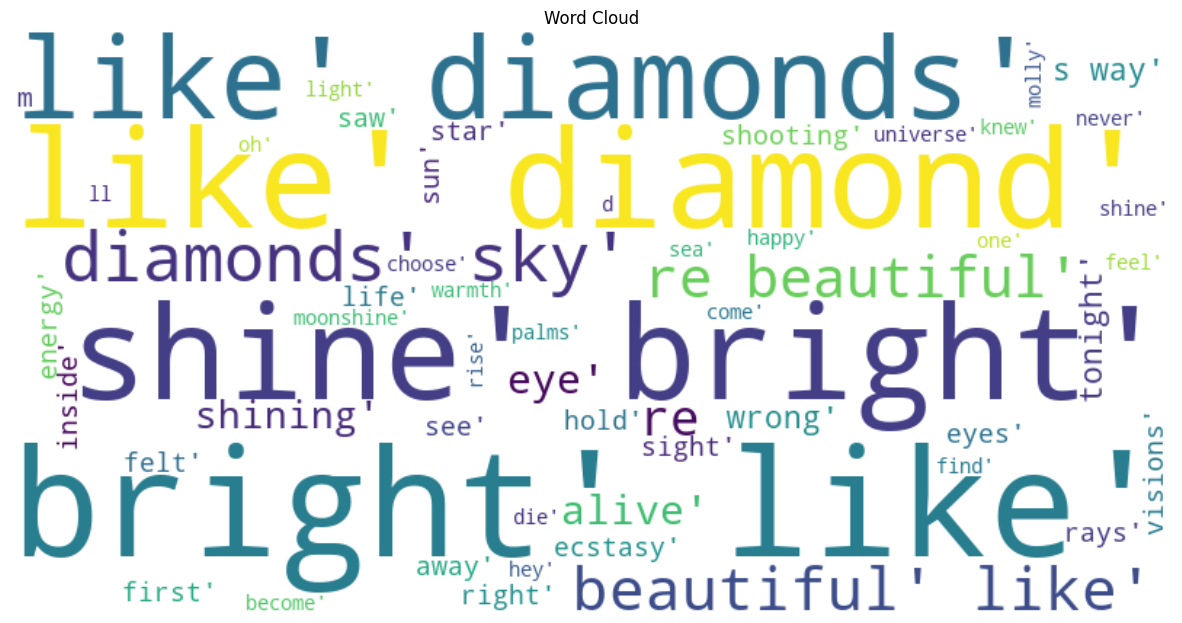

In [ ]:
wordcloud = WordCloud(width = 800, height = 400, 
                      random_state=21, max_font_size=110, 
                      background_color='white').generate(str(a))

# Plot the word cloud
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Word Cloud')
plt.show()

In [ ]:
str(a)

'[\'shine\', \'bright\', \'like\', \'diamond\', \'shine\', \'bright\', \'like\', \'diamond\', \'shining\', \'bright\', \'like\', \'diamond\', \'find\', \'light\', \'beautiful\', \'sea\', \'choose\', \'happy\', \',\', "\'re", \'like\', \'diamonds\', \'sky\', "\'re", \'shooting\', \'star\', \'see\', \'visions\', \'ecstasy\', \'hold\', \',\', "\'m", \'alive\', "\'re", \'like\', \'diamonds\', \'sky\', \'knew\', "\'d", \'become\', \'one\', \'right\', \'away\', \'oh\', \',\', \'right\', \'away\', \'first\', \'sight\', \'felt\', \'energy\', \'sun\', \'rays\', \'saw\', \'life\', \'inside\', \'eyes\', \'shine\', \'bright\', \',\', \'tonight\', "\'re", \'beautiful\', \'like\', \'diamonds\', \'sky\', \'eye\', \'eye\', \',\', \'alive\', "\'re", \'beautiful\', \'like\', \'diamonds\', \'sky\', \'shine\', \'bright\', \'like\', \'diamond\', \'shine\', \'bright\', \'like\', \'diamond\', \'shining\', \'bright\', \'like\', \'diamond\', "\'re", \'beautiful\', \'like\', \'diamonds\', \'sky\', \'shine\', \'

In [ ]:
str(filtered_df)

'5277    [shine, bright, like, diamond, shine, bright, ...\nName: lyrics, dtype: object'

# MERVE: 

Es gibt im Dataset sehr viele Tokens mit nur Sonderzeichen drinnen... vielleicht habe ich auch was übersehen.. unten siehst du die top 20 common_words und da tauchen sehr viele Sonderzeichen auf.. ich hab versucht, die lyrics zu cleanen und komm auf ein besseres ergebnis.. unten noch ein paar Grafiken, die wir im Unterricht erwähnt wurden.. kannst dir aussuchen was du drin haben möchtest

In [55]:
# Flattening the list and counting occurrences of each word
all_words = [word for sublist in tracks_lang_no_dup['lyrics'] for word in sublist]
word_frequencies = Counter(all_words)

common_words = word_frequencies.most_common(20)
common_words

[(',', 514672),
 ("n't", 112050),
 ("'s", 96968),
 (')', 85018),
 ('(', 84974),
 ("'m", 72936),
 ("'", 57548),
 ('?', 55461),
 ('like', 55061),
 ('know', 53207),
 ('.', 51952),
 ('’', 51830),
 ('love', 51435),
 ('got', 45881),
 ('oh', 43801),
 ('na', 43128),
 ('yeah', 39610),
 ("'re", 38794),
 ('``', 34980),
 ('get', 32874)]

In [60]:
import re

tracks_lang_no_dup['lyrics_clean'] = tracks_lang_no_dup['lyrics'].apply(lambda x: [re.sub(r'[^a-zA-Z]', '', text) for text in x])
#df_artists['cleaned_genres'] = df_artists['genres'].apply(lambda x: [re.sub(r'[^a-zA-Z\s]', '', genre) for genre in x])


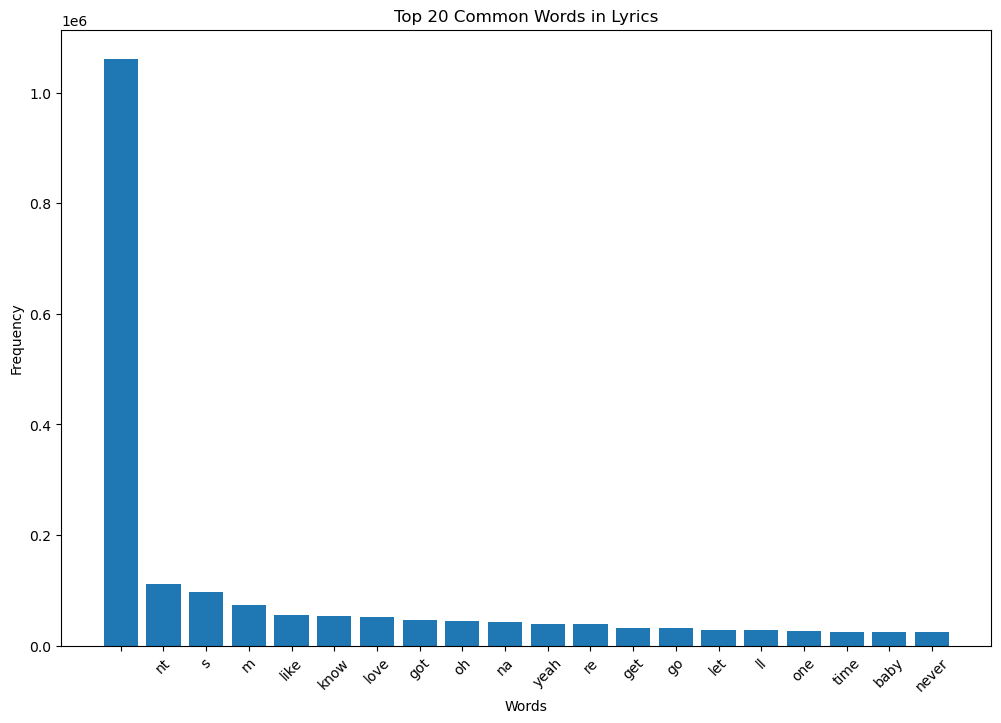

In [59]:
# Flattening the list and counting occurrences of each word
all_words = [word for sublist in tracks_lang_no_dup['lyrics_clean'] for word in sublist]
word_frequencies = Counter(all_words)

# Visualizing the most common words
common_words = word_frequencies.most_common(20)
labels, values = zip(*common_words)

plt.figure(figsize=(12, 8))
plt.bar(labels, values)
plt.title('Top 20 Common Words in Lyrics')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

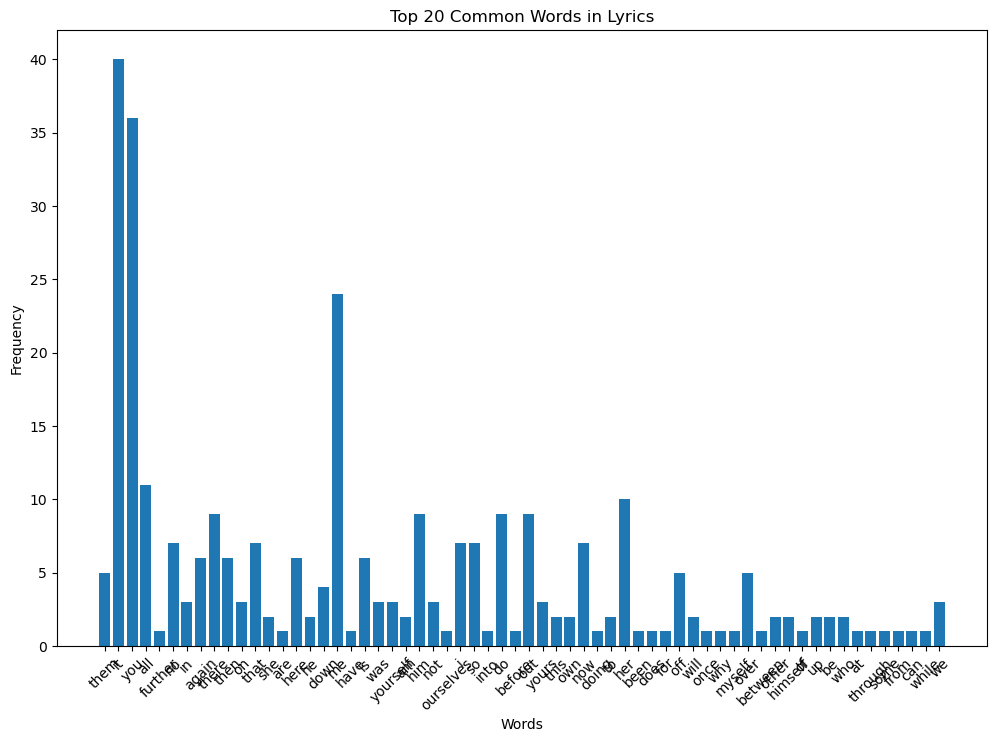

In [52]:
# extract all genres from the cleaned_genres column
all_genres = [genre for sublist in tracks_lang_no_dup['lyrics'] for genre in sublist]
genres_stopwords = [word for word in all_genres if word.lower() in stop_words]

# count of stopwords in genres data
stopword_counts = Counter(genres_stopwords)
stopword_counts


plt.figure(figsize=(12, 8))
plt.bar(stopword_counts.keys(), stopword_counts.values())
plt.title('Top 20 Common Words in Lyrics')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

In [41]:
import textstat

def calculate_readability_metrics(text):
    try:
        ari = textstat.automated_readability_index(text)
        fre = textstat.flesch_reading_ease(text)
        fkgl = textstat.flesch_kincaid_grade(text)
        gfi = textstat.gunning_fog(text)
    except:
        ari, fre, fkgl, gfi = [None]*4  
    
    return pd.Series((ari, fre, fkgl, gfi))

tracks_lang_no_dup['lyrics_str'] = tracks_lang_no_dup['lyrics'].astype(str)
tracks_lang_no_dup[['ARI', 'FRE', 'FKGL', 'GFI']] = tracks_lang_no_dup['lyrics_str'].apply(calculate_readability_metrics)

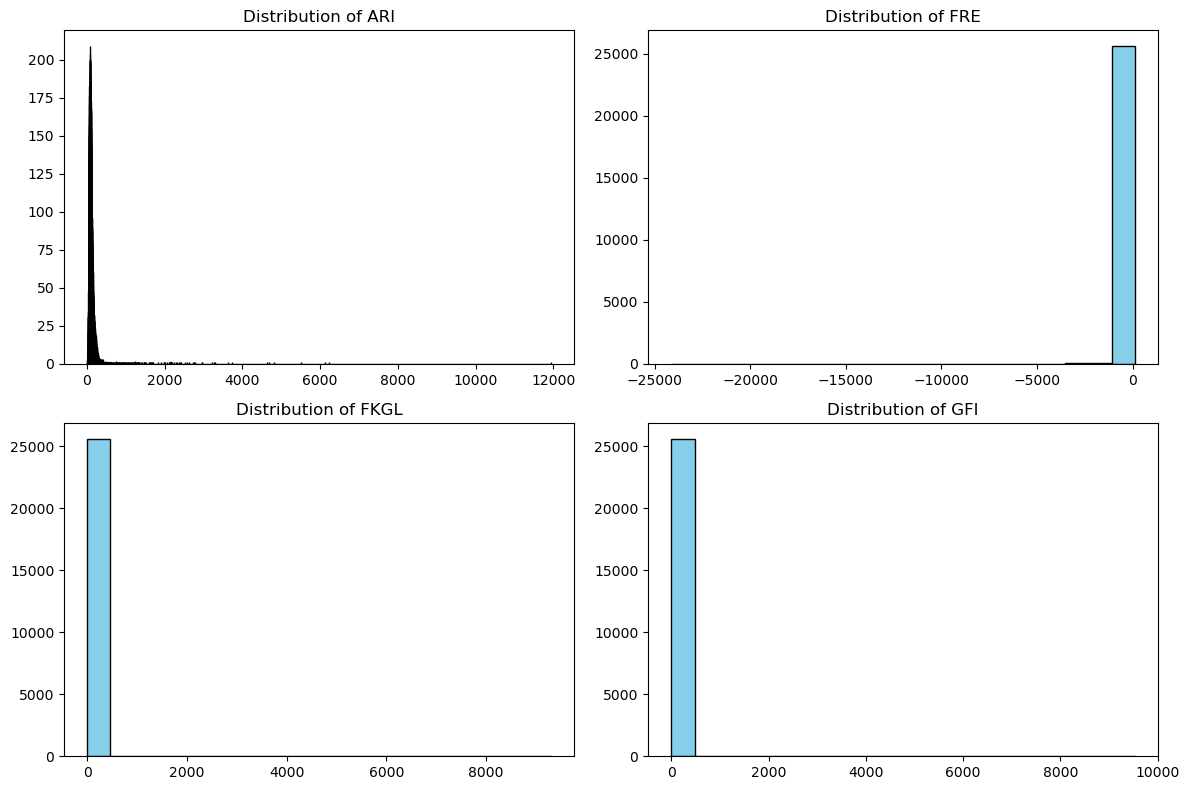

In [45]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Histogram of ARI
axs[0, 0].hist(tracks_lang_no_dup['ARI'].dropna(), bins=20000, color='skyblue', edgecolor='black')
axs[0, 0].set_title('Distribution of ARI')

# Histogram of FRE
axs[0, 1].hist(tracks_lang_no_dup['FRE'].dropna(), bins=20, color='skyblue', edgecolor='black')
axs[0, 1].set_title('Distribution of FRE')

# Histogram of FKGL
axs[1, 0].hist(tracks_lang_no_dup['FKGL'].dropna(), bins=20, color='skyblue', edgecolor='black')
axs[1, 0].set_title('Distribution of FKGL')

# Histogram of GFI
axs[1, 1].hist(tracks_lang_no_dup['GFI'].dropna(), bins=20, color='skyblue', edgecolor='black')
axs[1, 1].set_title('Distribution of GFI')

plt.tight_layout()
plt.show()


In [62]:
# Descriptive statistics for each metric
print(tracks_lang_no_dup[['ARI', 'FRE', 'FKGL', 'GFI']].describe())


                ARI           FRE          FKGL           GFI
count  25732.000000  25732.000000  25732.000000  25732.000000
mean     109.543926   -103.088404     73.369835     74.604013
std      159.038391    324.756581    124.023725    126.907707
min        7.300000 -24133.240000     -3.500000      0.400000
25%       68.100000   -127.820000     41.100000     41.600000
50%       89.000000    -61.490000     57.500000     58.400000
75%      121.100000    -17.170000     82.500000     83.780000
max    11935.200000    121.220000   9297.400000   9530.170000
